# Tradictional frecuency approach for text classification

Traditional approaches come to improve text models that worked only with bag-of-words. TFIDF was developed as an alternative that looks at the frequency of words in the vocabulary allowing us to run a traditional ML algorithm on top of these features to obtain text classification. It works very well when we have texts of different classes with a differentiable vocabulary. However, it does not take into account the order of the words in the text nor their semantic or contextual meaning.

<br>

For this notebook we are going to use the TFIDF processing of the sklearn library that we can consult in the following link:

https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html


In [ ]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from decimal import Decimal, ROUND_HALF_DOWN

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import classification_report, recall_score

In [ ]:
def custom_round(number, decimal_places=1):
    rounded_number = Decimal(number).quantize(Decimal('0.0' + '1' * decimal_places), rounding=ROUND_HALF_DOWN)
    return float(rounded_number)

def viz_top_terms(tfidf_values, feature_names):
  # Calculate the mean TF-IDF scores across all documents
  mean_tfidf_scores = np.mean(tfidf_values, axis=0)

  # Create a dictionary mapping feature names (terms) to their mean TF-IDF scores
  term_tfidf_dict = dict(zip(feature_names, mean_tfidf_scores))

  # Sort the terms by their TF-IDF scores in descending order
  sorted_terms = sorted(term_tfidf_dict.items(), key=lambda x: x[1], reverse=True)

  # Select the top N terms to visualize (e.g., top 20)
  top_n = 20
  top_terms, top_scores = zip(*sorted_terms[:top_n])

  # Create a bar chart to visualize the top N terms and their TF-IDF scores
  plt.figure(figsize=(12, 6))
  plt.barh(top_terms, top_scores, color='skyblue')
  plt.xlabel('Mean TF-IDF Score')
  plt.title(f'Top {top_n} Terms by TF-IDF')
  plt.gca().invert_yaxis()  # Invert y-axis to display highest TF-IDF at the top
  plt.show()

In [ ]:
def plot_feature_effects(tfidf_matrix, categories):
    """
        https://scikit-learn.org/stable/auto_examples/text/plot_document_classification_20newsgroups.html
    """
    # learned coefficients weighted by frequency of appearance
    average_feature_effects = clf.coef_ * np.asarray(tfidf_matrix.mean(axis=0)).ravel()

    for i, label in enumerate(categories):
        top5 = np.argsort(average_feature_effects[i])[-5:][::-1]
        if i == 0:
            top = pd.DataFrame(feature_names[top5], columns=[label])
            top_indices = top5
        else:
            top[label] = feature_names[top5]
            top_indices = np.concatenate((top_indices, top5), axis=None)
    top_indices = np.unique(top_indices)
    predictive_words = feature_names[top_indices]

    # plot feature effects
    bar_size = 0.25
    padding = 0.75
    y_locs = np.arange(len(top_indices)) * (4 * bar_size + padding)

    fig, ax = plt.subplots(figsize=(10, 8))
    for i, label in enumerate(categories):
        ax.barh(
            y_locs + (i - 2) * bar_size,
            average_feature_effects[i, top_indices],
            height=bar_size,
            label=label,
        )
    ax.set(
        yticks=y_locs,
        yticklabels=predictive_words,
        ylim=[
            0 - 4 * bar_size,
            len(top_indices) * (4 * bar_size + padding) - 4 * bar_size,
        ],
    )
    ax.legend(loc="lower right")

    print("top 5 keywords per class:")
    print(top)
    print()

    return ax

## Classifier model using TDIDF


The objective of this section is to apply TFIDF on the 20newsgroups dataset, which consists of news on 20 topics from which we will select the following 5 to reduce the complexity of the exercise:
- *talk.politics.guns*
- *sci.space*
- *sci.med*
- *comp.windows.x*
- *alt.atheism*

The idea is to start from a raw text and a TIDf with the default parameters and explore all the alternatives we have to improve the models with this approach.

Doc: https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_20newsgroups.html#sklearn.datasets.fetch_20newsgroups


In [ ]:
# Load the 20 Newsgroups dataset (only 5 categroies)
categories = ['talk.politics.guns',
              'sci.space',
              'sci.med',
              'comp.windows.x',
              'alt.atheism']

data_train = fetch_20newsgroups(
    subset="train",
    categories=categories,
    shuffle=True,
    random_state=42,
)

data_test = fetch_20newsgroups(
    subset="test",
    categories=categories,
    shuffle=True,
    random_state=42,
)

pd.Series(data_train.target).value_counts()

2    594
1    593
3    593
4    546
0    480
dtype: int64

In [ ]:
# Extract the text data (newsgroup posts) and target labels
X_train, y_train = data_train.data, data_train.target
X_test, y_test = data_test.data, data_test.target

# Initialize the TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Fit and transform the text data to calculate TF-IDF values
tfidf_matrix = tfidf_vectorizer.fit_transform(X_train)

# Get the feature names (terms) and TF-IDF values as a dense array
feature_names = tfidf_vectorizer.get_feature_names_out()
tfidf_values = tfidf_matrix.toarray()

In [ ]:
# clf = RandomForestClassifier(max_depth=5, random_state=0)
# clf.fit(tfidf_values, y_train)

clf = RidgeClassifier(tol=1e-2, solver="sparse_cg")
clf.fit(tfidf_matrix, y_train)

RidgeClassifier(solver='sparse_cg', tol=0.01)

In [ ]:
y_hat_test = clf.predict(tfidf_vectorizer.transform(X_test))

print('Evaluate test')
print(classification_report(y_test, y_hat_test, target_names=categories))

Evaluate test
                    precision    recall  f1-score   support

talk.politics.guns       0.97      0.92      0.95       319
         sci.space       0.91      0.98      0.94       395
           sci.med       0.93      0.92      0.93       396
    comp.windows.x       0.95      0.95      0.95       394
       alt.atheism       0.98      0.96      0.97       364

          accuracy                           0.95      1868
         macro avg       0.95      0.95      0.95      1868
      weighted avg       0.95      0.95      0.95      1868



top 5 keywords per class:
  talk.politics.guns sci.space sci.med comp.windows.x alt.atheism
0                 is    window      of          space         the
1                edu     motif      is            the         gun
2                 of      with     and           nasa         com
3                you        to      it            was          to
4                god        an      my         access        guns



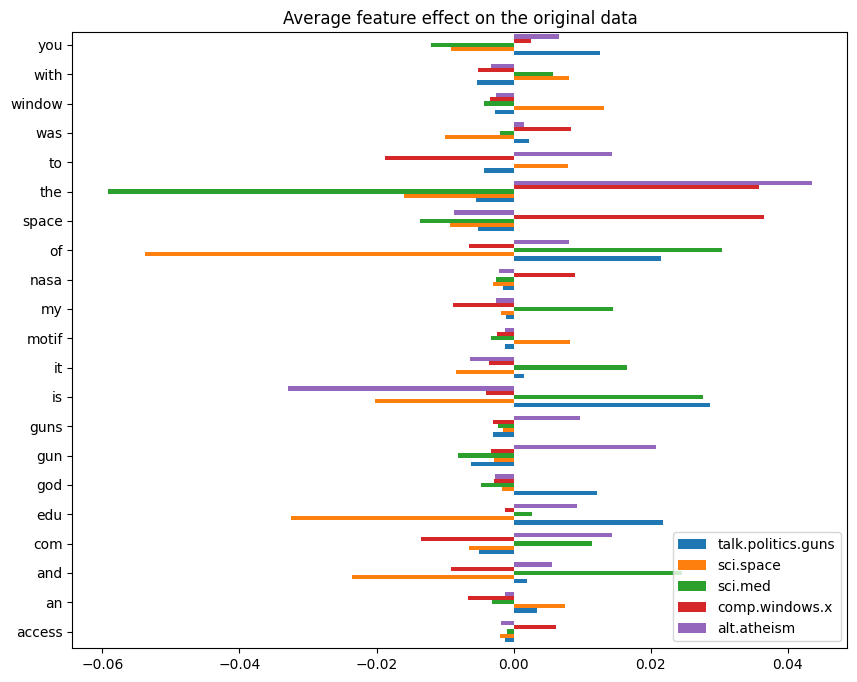

In [ ]:
_ = plot_feature_effects(tfidf_matrix, categories).set_title("Average feature effect on the original data")

## Improve TFIDF with text preprocessing

### 1. Stopwords

Set of commonly used words in any language. We have several libraries where we can load predefined sets for various languages or apply frecuency analysis in order to detect them.

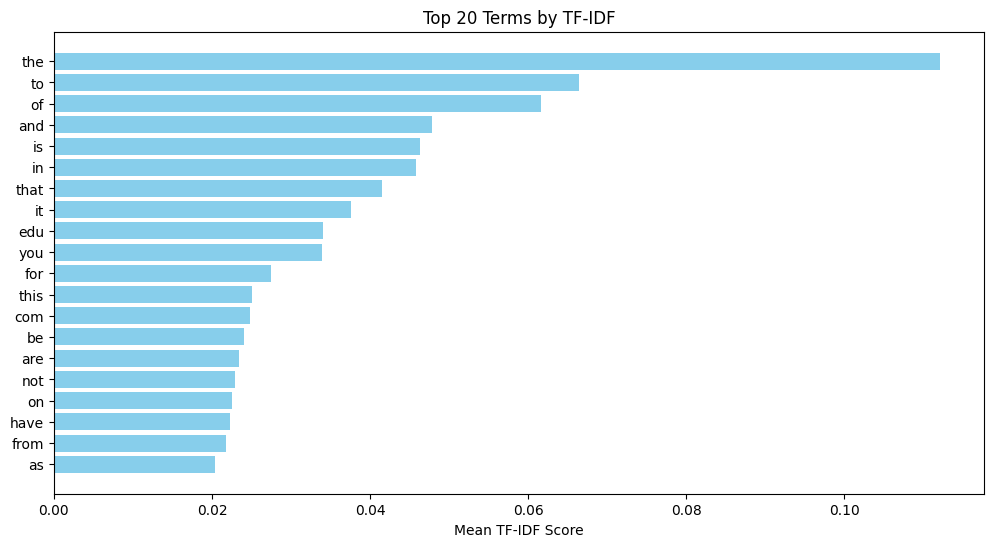

In [ ]:
# We can check that are several words that are not contribute to our model
viz_top_terms(tfidf_values, feature_names)

#### List of predifined stopwords

In [ ]:
# Loca english stopwords
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# TFIDF
tfidf_vectorizer = TfidfVectorizer(stop_words=stopwords.words('english'))
tfidf_matrix = tfidf_vectorizer.fit_transform(X_train)
feature_names = tfidf_vectorizer.get_feature_names_out()
tfidf_values = tfidf_matrix.toarray()

# Model
clf = RidgeClassifier(tol=1e-2, solver="sparse_cg")
clf.fit(tfidf_matrix, y_train)

# Results
y_hat_test = clf.predict(tfidf_vectorizer.transform(X_test))
print('Evaluate test')
print(classification_report(y_test, y_hat_test, target_names=categories))

Evaluate test
                    precision    recall  f1-score   support

talk.politics.guns       0.97      0.92      0.94       319
         sci.space       0.91      0.97      0.94       395
           sci.med       0.93      0.93      0.93       396
    comp.windows.x       0.95      0.95      0.95       394
       alt.atheism       0.98      0.97      0.97       364

          accuracy                           0.95      1868
         macro avg       0.95      0.95      0.95      1868
      weighted avg       0.95      0.95      0.95      1868



#### Detect stopwords with term frecuency

Sometimes the vocabulary can be very large and we want to reduce it to have the necessary features without adding noise. We can do this in two ways:

- Removing the less frequent words `min_df`: if a word only appears 1 or 2 times in our dataset for our frequency analysis probably they will be a misspelled word or irrelevant term.
- Removing the most used words `max_df`: If there are certain words that are repeated in almost all documents, they are probably stopwords in our dataset that can be eliminated.

In [ ]:
# TFIDF
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2)
tfidf_matrix = tfidf_vectorizer.fit_transform(X_train)
feature_names = tfidf_vectorizer.get_feature_names_out()
tfidf_values = tfidf_matrix.toarray()

# Model
clf = RidgeClassifier(tol=1e-2, solver="sparse_cg")
clf.fit(tfidf_matrix, y_train)

# Results
y_hat_test = clf.predict(tfidf_vectorizer.transform(X_test))
print('Evaluate test')
print(classification_report(y_test, y_hat_test, target_names=categories))

Evaluate test
                    precision    recall  f1-score   support

talk.politics.guns       0.97      0.91      0.94       319
         sci.space       0.92      0.97      0.94       395
           sci.med       0.93      0.93      0.93       396
    comp.windows.x       0.95      0.95      0.95       394
       alt.atheism       0.98      0.97      0.97       364

          accuracy                           0.95      1868
         macro avg       0.95      0.95      0.95      1868
      weighted avg       0.95      0.95      0.95      1868



### Remove accents and punctuation

To get a better processing and reach a standardized text, another common step is to delete accents and punctuation symbols.

In [ ]:
# 1. remove punctuation
import string

def preprocess_and_remove_punctuation(text):
    # Remove punctuation using Python's string.punctuation
    translator = str.maketrans('', '', string.punctuation)
    text = text.translate(translator)
    return text

# Preprocess train and test
X_train_norm = [preprocess_and_remove_punctuation(doc) for doc in X_train]
X_test_norm = [preprocess_and_remove_punctuation(doc) for doc in X_test]

In [ ]:
# 2. remove accents

# TFIDF
tfidf_vectorizer = TfidfVectorizer(strip_accents='unicode')
tfidf_matrix = tfidf_vectorizer.fit_transform(X_train_norm)
feature_names = tfidf_vectorizer.get_feature_names_out()
tfidf_values = tfidf_matrix.toarray()

# Model
clf = RidgeClassifier(tol=1e-2, solver="sparse_cg")
clf.fit(tfidf_matrix, y_train)

# Results
y_hat_test = clf.predict(tfidf_vectorizer.transform(X_test_norm))
print('Evaluate test')
print(classification_report(y_test, y_hat_test, target_names=categories))

Evaluate test
                    precision    recall  f1-score   support

talk.politics.guns       0.96      0.91      0.93       319
         sci.space       0.91      0.98      0.95       395
           sci.med       0.94      0.93      0.94       396
    comp.windows.x       0.97      0.93      0.95       394
       alt.atheism       0.96      0.96      0.96       364

          accuracy                           0.95      1868
         macro avg       0.95      0.94      0.95      1868
      weighted avg       0.95      0.95      0.95      1868



### N-grams

An n-gram is a collection of n successive items in a text document. Can be useful when some word are complemented to each other. E.g "*transport line*", "*super star*", "*power supply*".



In [ ]:
# TFIDF
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2))      # we include n-grams from 1 to 2 words (could slow donw our process)
tfidf_matrix = tfidf_vectorizer.fit_transform(X_train)
feature_names = tfidf_vectorizer.get_feature_names_out()
tfidf_values = tfidf_matrix.toarray()

# Model
clf = RidgeClassifier(tol=1e-2, solver="sparse_cg")
clf.fit(tfidf_matrix, y_train)

# Results
y_hat_test = clf.predict(tfidf_vectorizer.transform(X_test))
print('Evaluate test')
print(classification_report(y_test, y_hat_test, target_names=categories))

Evaluate test
                    precision    recall  f1-score   support

talk.politics.guns       0.97      0.93      0.95       319
         sci.space       0.90      0.97      0.94       395
           sci.med       0.94      0.92      0.93       396
    comp.windows.x       0.95      0.93      0.94       394
       alt.atheism       0.97      0.97      0.97       364

          accuracy                           0.94      1868
         macro avg       0.95      0.94      0.95      1868
      weighted avg       0.95      0.94      0.94      1868



### Stemming

Stemming is a natural language processing technique that is used to reduce words to their base form, also known as the root form. It usually relies on dictionaries to map words to their standardized version.

In [ ]:
# Donwload stemmer
from nltk.stem import PorterStemmer

nltk.download('stopwords')
nltk.download('punkt')
stemmer = PorterStemmer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
%%time

stemmer = PorterStemmer()

def preprocess_and_stem(text):
    # Tokenize the text
    tokens = nltk.word_tokenize(text.lower())
    # Stem the words
    stemmed_tokens = [stemmer.stem(word) for word in tokens]

    return ' '.join(stemmed_tokens)


# Preprocess and stem the documents
X_train_st = [preprocess_and_stem(doc) for doc in X_train]
X_test_st = [preprocess_and_stem(doc) for doc in X_test]

CPU times: user 38.4 s, sys: 90.6 ms, total: 38.5 s
Wall time: 38.7 s


In [ ]:
# TFIDF
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(X_train_st)
feature_names = tfidf_vectorizer.get_feature_names_out()
tfidf_values = tfidf_matrix.toarray()

# Model
clf = RidgeClassifier(tol=1e-2, solver="sparse_cg")
clf.fit(tfidf_matrix, y_train)

# Results
y_hat_test = clf.predict(tfidf_vectorizer.transform(X_test_st))
print('Evaluate test')
print(classification_report(y_test, y_hat_test, target_names=categories))

Evaluate test
                    precision    recall  f1-score   support

talk.politics.guns       0.97      0.94      0.96       319
         sci.space       0.92      0.98      0.95       395
           sci.med       0.95      0.93      0.94       396
    comp.windows.x       0.96      0.95      0.95       394
       alt.atheism       0.98      0.97      0.98       364

          accuracy                           0.95      1868
         macro avg       0.96      0.95      0.95      1868
      weighted avg       0.95      0.95      0.95      1868



### Lemmatization

Takes a word and breaks it down to its lemma. It usually relies on models pretrained in different languages.

In [ ]:
import spacy

# Load spaCy's English language model
nlp = spacy.load("en_core_web_sm")

In [ ]:
%%time

def preprocess_and_lemmatize(text):
    # Parse the text using spaCy
    doc = nlp(text)
    # Lemmatize and remove punctuation
    lemmatized_tokens = [token.lemma_ for token in doc if token.is_alpha]
    # Join the lemmatized tokens back into a string
    return ' '.join(lemmatized_tokens)

# Preprocess and lemmatize the documents
X_train_lm = [preprocess_and_lemmatize(doc) for doc in X_train]
X_test_lm = [preprocess_and_lemmatize(doc) for doc in X_test]

CPU times: user 6min 20s, sys: 3.05 s, total: 6min 23s
Wall time: 6min 25s


In [ ]:
# TFIDF
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(X_train_lm)
feature_names = tfidf_vectorizer.get_feature_names_out()
tfidf_values = tfidf_matrix.toarray()

# Model
clf = RidgeClassifier(tol=1e-2, solver="sparse_cg")
clf.fit(tfidf_matrix, y_train)

# Results
y_hat_test = clf.predict(tfidf_vectorizer.transform(X_test_lm))
print('Evaluate test')
print(classification_report(y_test, y_hat_test, target_names=categories))

Evaluate test
                    precision    recall  f1-score   support

talk.politics.guns       0.94      0.92      0.93       319
         sci.space       0.93      0.98      0.95       395
           sci.med       0.95      0.93      0.94       396
    comp.windows.x       0.95      0.94      0.95       394
       alt.atheism       0.97      0.96      0.97       364

          accuracy                           0.95      1868
         macro avg       0.95      0.95      0.95      1868
      weighted avg       0.95      0.95      0.95      1868



### POS-tagging

Part-of-speech (POS) tagging is a process in natural language processing (NLP) where each word in a text is labeled with its corresponding part of speech. This can include nouns, verbs, adjectives, and other grammatical categories. It usually relies on models pretrained in different languages.

<br>

https://spacy.io/usage/linguistic-features


In [ ]:
%%time

def preprocess_and_extract_nouns(text):
    # Parse the text using spaCy
    doc = nlp(text)
    # Extract nouns (NOUNs) and convert them to lowercase
    nouns = [token.text.lower() for token in doc if token.pos_ in ["NOUN", "PROPN"]]
    # Join the nouns back into a string
    return ' '.join(nouns)


# Preprocess and lemmatize the documents
X_train_pos = [preprocess_and_extract_nouns(doc) for doc in X_train]
X_test_pos = [preprocess_and_extract_nouns(doc) for doc in X_test]

CPU times: user 6min 10s, sys: 3.53 s, total: 6min 13s
Wall time: 6min 15s


In [ ]:
# TFIDF
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(X_train_pos)
feature_names = tfidf_vectorizer.get_feature_names_out()
tfidf_values = tfidf_matrix.toarray()

# Model
clf = RidgeClassifier(tol=1e-2, solver="sparse_cg")
clf.fit(tfidf_matrix, y_train)

# Results
y_hat_test = clf.predict(tfidf_vectorizer.transform(X_test_pos))
print('Evaluate test')
print(classification_report(y_test, y_hat_test, target_names=categories))

Evaluate test
                    precision    recall  f1-score   support

talk.politics.guns       0.96      0.92      0.94       319
         sci.space       0.91      0.97      0.94       395
           sci.med       0.94      0.91      0.92       396
    comp.windows.x       0.95      0.96      0.96       394
       alt.atheism       0.97      0.96      0.96       364

          accuracy                           0.94      1868
         macro avg       0.95      0.94      0.95      1868
      weighted avg       0.95      0.94      0.94      1868



## Exercise span dataset

Let's apply the spam detection dataset to sms texts.

https://archive.ics.uci.edu/dataset/228/sms+spam+collection



We must perform the following steps:
- Apply at least 2 of the above word processing techniques. It is important to apply them in the correct order and give reasons why.
- Generate TFIDF
- Use a custom classfier without changing hyperparams (we want to improve our model based on our data preprocessing)
- Obtain a `test SPAM recall >= 0.9`

<br>

**IMPORTANT**: if you want to reuse preprocess functions, you can do it but now we are dealing with pandas so we have to call them a litle bit different:
```
X_train = X_train.apply(preprocess_and_stem)
```

In [ ]:
import pandas as pd
import urllib.request
import zipfile
import os
from sklearn.model_selection import train_test_split

# Define the URL of the dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip"

# Define the directory where you want to save and extract the dataset
download_dir = "./sms_spam_collection"

# Create the directory if it doesn't exist
if not os.path.exists(download_dir):
    os.makedirs(download_dir)

# Download the dataset file
print("Downloading SMS Spam Collection dataset...")
urllib.request.urlretrieve(url, os.path.join(download_dir, "sms_spam_collection.zip"))

# Extract the dataset from the ZIP file
print("Extracting dataset...")
with zipfile.ZipFile(os.path.join(download_dir, "sms_spam_collection.zip"), "r") as zip_ref:
    zip_ref.extractall(download_dir)

# Read the dataset into a pandas DataFrame
sms_df = pd.read_csv(os.path.join(download_dir, "SMSSpamCollection"), sep='\t', names=["label", "message"])

print(sms_df.label.value_counts())
sms_df.head()

Extracting dataset...
ham     4825
spam     747
Name: label, dtype: int64


,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
# Split the dataset into features (X) and labels (y)
X = sms_df['message']
y = sms_df['label']

# Split the data into training and testing sets (80% train, 20% test) with stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=42, stratify=y)

# Display the shapes of the resulting datasets
print("Training set shape (X_train, y_train):", X_train.shape, y_train.shape)
print("Testing set shape (X_test, y_test):", X_test.shape, y_test.shape)

Training set shape (X_train, y_train): (3621,) (3621,)
Testing set shape (X_test, y_test): (1951,) (1951,)


In [ ]:
%%time
# Preprocessing (your code here)
en_stopwords = stopwords.words('english')

# Apply preprocessing
X_train = X_train.apply(preprocess_and_remove_punctuation)
X_train = X_train.apply(preprocess_and_extract_nouns)

# Initialize the TF-IDF vectorizer (your code here)
tfidf_vectorizer = TfidfVectorizer(stop_words=en_stopwords, min_df=2, ngram_range=(1, 2), strip_accents='unicode')

CPU times: user 33.2 s, sys: 108 ms, total: 33.3 s
Wall time: 33.4 s


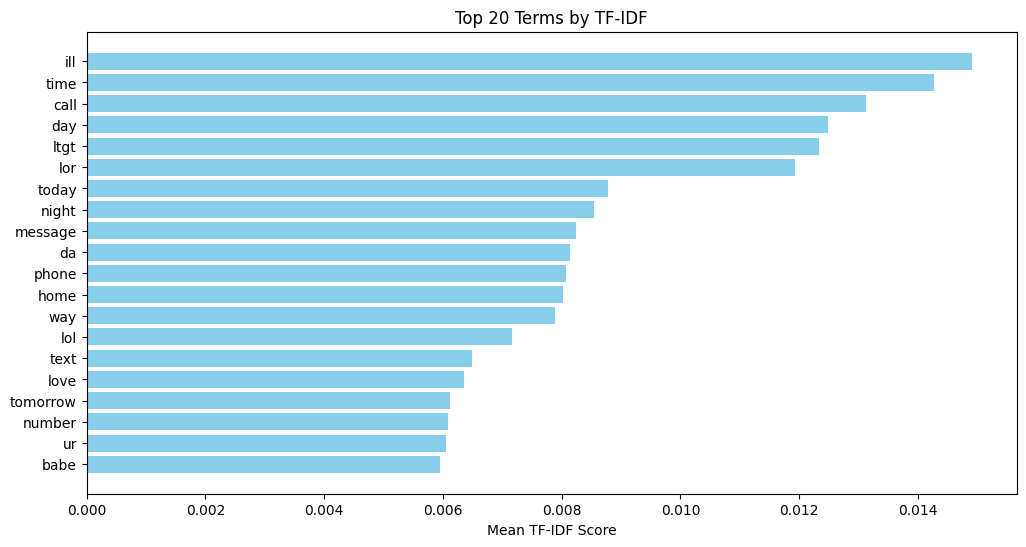

In [ ]:
# TFIDF
tfidf_matrix = tfidf_vectorizer.fit_transform(X_train)
feature_names = tfidf_vectorizer.get_feature_names_out()
tfidf_values = tfidf_matrix.toarray()
viz_top_terms(tfidf_values, feature_names)

In [ ]:
# Model
clf = RidgeClassifier(tol=1e-2, solver="sparse_cg", random_state=0)
clf.fit(tfidf_matrix, y_train)

y_hat_test = clf.predict(tfidf_vectorizer.transform(X_test))
print('Evaluate test')
print(classification_report(y_test, y_hat_test))

assert custom_round(recall_score(y_test, y_hat_test, average='binary', pos_label='spam'), 1) >= 0.9

Evaluate test
              precision    recall  f1-score   support

         ham       0.98      0.99      0.99      1689
        spam       0.91      0.90      0.91       262

    accuracy                           0.97      1951
   macro avg       0.95      0.94      0.95      1951
weighted avg       0.97      0.97      0.97      1951

